# United Nations Voting Patterns
#### [CMSC320 Final Tutorial]
Authors: Lauren Brown, Angel Lin


**TODO**
* get rid of requests we don't use and add requests from the k means clustering and other analysis stuff
* add NaN for all countries not present 

## **Introduction**

### **United Nations Overview**

The United Nations (UN) is an international organization founded immediately after World War II. The purpose of the UN is to maintain international peace and security, provide humanitarian assistance to those in need, protect human rights, and promote economic development. It pursues these goals through several bodies, including:
* the General Assembly, the main deliberative body, which includes one seat for each recognized member-state. Many committees and subcommittees help to form and inform policies within their specific jurisdictions that may be considered by the GA;
* the Security Council, a body comprised of 15 member states, including 5 permanent members, which is tasked with dealing with threats to international peace and security;
* the International Court of Justice (ICJ) which settles international legal disputes between countries and gives advice to the UN when requested; and 
* the Secretariat, which consists of staff from all over the world and carries out the day to day operations of the UN.

#### **Background Readings**
For more information regarding:
* the founding and history of the United Nations: [click here](https://www.history.com/topics/world-war-ii/united-nations).
* the structure of the United Nations, [click here](https://guides.lib.fsu.edu/c.php?g=946756&p=6852483).

This project and methodology were based on a similar one tracking the change in Congress partisanship over time, which you can read more on [here](https://dspace.mit.edu/bitstream/handle/1721.1/97109/Andris-2015-The%20rise%20of%20partisan.pdf?sequence=1&isAllowed=y).

### **Motivation**

This tutorial looks at how countries in the United Nations vote with respect to other countries. We ask the question, as countries rise and fall, how do UN voting patterns shift, if at all? How do voting blocs form and dissipate over time? If we can discover which countries are at the center of voting blocs, we may be able to determine which countries will be most able to influence the outcomes of UN resolutions. 

In this project, we will follow the data science pipeline which includes the steps of data collection, data processing, analysis, and insight & policy decision. To do this, we use an adjacency matrix to create graphs, in order to determine how similarly countries vote compared to each other and visualize how voting blocs have formed and changed over time. We hypothesize that as countries rise and fall from power, clusters will form and dissolve around these countries. The null hypothesis, then, is that there is no relationship between any voting blocs that may form and the rise and fall of countries.

Specifically, the countries we are interested in for this dataset are the United States, the Soviet Union, and China. These three countries have been major world players since the founding of the United Nations, and while we will be looking for the center of voting blocs regardless of who it may be, these three countries will be highlighted throughout our data exploration and analysis. 

### **Required Libraries and Tools**

This project utilizes the Python3 languages and packages to collect, explore, visualize, and analyze the data. To reproduce the code, please ensure you have the following packages installed; you can install any of these by using the command <code>$ pip3 install [package]</code> in your terminal or command prompt. 

* <code>reqests</code>: allows us to retrieve website data using Python [(docs)](https://docs.python-requests.org/en/latest/)
* <code>BeautifulSoup</code>: allows us to parse and scrape HTML after retrieving website data [(docs)](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
* <code>numpy</code>: supports a wide range of operations. Required for Pandas installation [(docs)](https://numpy.org/)
* <code>pandas</code>: used for data manipulation and analysis [(docs)](https://pandas.pydata.org/)
* <code>time</code>: allows us to create delays in code operations [(docs)](https://docs.python.org/3/library/time.html)
* <code>datetime</code>: used for parsing date strings into objects [(docs)](https://docs.python.org/3/library/datetime.html)
* <code>matplotlib</code>: includes an extraordinary amount of data visualization functions [(docs)](https://matplotlib.org/)
* <code>networkx</code>: allows us to display and manipulate graphs [(docs)](https://networkx.org/documentation/stable/index.html)

In [96]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
import networkx as nx

# this import simply assists with the visual cohesiveness of this page.
import warnings
warnings.filterwarnings("ignore")

## **Data Collection and Processing** 

### **UN Subjects** 

The United Nations keeps all its resolution data on their [digital library website](https://digitallibrary.un.org/), in which anyone can search through any resolution, speech, or any other document from the UN. After filtering to just [General Assembly voting data](https://digitallibrary.un.org/search?ln=en&cc=Voting%20Data&p=&f=&rm=&ln=en&sf=&so=d&rg=50&c=Voting%20Data&c=&of=hb&fti=0&fct__2=General%20Assembly&fti=0&fct__2=General%20Assembly&fct__9=Vote), there are almost 7000 resolutions from 1946 to 2022. For the first step of the Data Science Pipeline, data collection, we will be gathering data from this site.

Since there is no API provided by the UN to easily access or filter all of the resolution data, we had to resort to scraping necessary data off of each resolution's webpage. Scraping is the process of using a bot to extract content and data from a website, so that we don't have to do it manually for each resolution. To determine which resolutions we wanted to use for our dataset, we decided to utilize the UN library website's ability to filter by different subjects to access certain resolutions. There are hundreds of subjects to filter by, some of which are contained within broader subjects. 

We saw no way to get around manually filtering through the subjects, and we placed each subject into the following broader categories of our own design: 
* International Peacekeeping/Security, and Weapons Agreements: Includes any resolutions about wars and conflicts (civil, between countries, etc), weapons agreements (nuclear, chemical, IAEA notes), security agreements, cybersecurity, post-war international judicial courts (ICJ/ICTY/ICTR), terrorism, Hostage-taking during wars, and more.
* Internal UN functioning: Includes budgets and resolutions discussing the functioning of the UN as a whole
* Economic: Includes any international economic treaties, economic rights of countries, and global trade
* Development: Includes human issues that the development status of a country might affect (like health), resolutions directly related to a country's development (infrastructure, development towards a specific country, etc.), and decolonization 
* Sustainability/environment: Includes any resolutions that may be related to climate change or how the environment has affected humans
* Human Rights/Humanitarian: Includes humanitarian assistance, disaster relief, human rights questions, etc. 

When determining which categories to use, we decided not to use international peacekeeping/security and weapons agreements, or internal functioning resolutions, because at the time we believed that there would not be enough disparity between countries in these resolutions, and that the inclusion of these resolutions may neutralize the other data we collected.[<sup>*</sup>](#fn1) We also were interested in development and human rights resolutions, and chose to include the other categories since they all either were directly related to this or were so influential to these topics that they could not be separated from them. 

After deciding on which categories to use, we still had over a hundred subjects to include in our dataset. As a final way of filtering, we chose a spread of subjects from each category that had the most number of resolutions in their category; this way, we could get the maximum "bang for our buck". 


<span id="fn1"><sup>*</sup></span>We have since found this to be somewhat of an error, since not only does our data visualization program account for these types of similarities but also many countries may disagree on country-specific resolutions related to international security. We discuss a bit more about this in our final notes at the very end of the project. 

### **Resolution Links** 

Code-wise, the first thing we needed to do was get a link to each resolution. We had already created csv files beforehand to store the links, so we simply read in each csv. While performing all our scraping, it was important to save all the data as we did it in case our program crashed or cut off, especially since our scraping permissions were unconfirmed by the UN. By always saving the resolution urls we scraped and ensuring that we also kept track of which subjects we visited, we ensured that we would never have to visit a website more than once and no data would be lost. 

In [76]:
category_links_df = pd.read_csv('category-links.csv')

visited_categories = pd.read_csv('visited_cats.csv')['visited categories'].tolist()
resolution_urls = pd.read_csv('res_urls.csv')['res_urls'].tolist()

category_links_df.head(5)

,un category,number of resolutions,link
0,HUMAN RIGHTS ADVANCEMENT,223,https://digitallibrary.un.org/search?ln=en&cc=...
1,UNRWA--ACTIVITIES,191,https://digitallibrary.un.org/search?ln=en&cc=...
2,DECOLONIZATION,121,https://digitallibrary.un.org/search?ln=en&cc=...
3,HUMAN RIGHTS--REPORTS,99,https://digitallibrary.un.org/search?ln=en&cc=...
4,APARTHEID,87,https://digitallibrary.un.org/search?ln=en&cc=...


To get the data from each resolution, we first had to get the links to each resolution. The following code is a function that we repeat for each subject; it retrieves the website data for each subject and adds the links to every resolution in the subject to a list. That list is then returned at the end of the function. If there are more than 50 resolutions in the subject, the subject may have more than one page to go through, and the function accounts for that as well. 

In [77]:
def get_res_links_from_page(page_link):
    
    links = []
    
    #get the page and parse it
    page = requests.get(page_link)
    if page.status_code != 200:
        raise Exception("Something went wrong loading category: " + category + ", error code: " + page.status_code)

    html = page.text
    soup = BeautifulSoup(html, 'html.parser')
    resolution_cnt = int(soup.find("strong", {"class": None}).text)

    #check for how many pages the subject has
    if resolution_cnt > 50:
        if resolution_cnt%50 == 0:
            page_count = (int) (resolution_cnt/50)
        else: page_count = int((resolution_cnt/50) + 1)
    else: page_count = 1
    
    #for each page, get every resolution listed on the page and add it to the list
    for page in range(page_count):

        for div in soup.find_all("div", {"class": "moreinfo"}):
            res_link_suffix = div.find("a")["href"]
            links.append('https://digitallibrary.un.org' + res_link_suffix)
        
        time.sleep(5)

        #load the next page if you're not already on the last page (0 indexing)
        if (page+1 != page_count):
            next_page_link_suffix = soup.find("span", {"class": "rec-navigation"}).findAll("a")[-1]["href"]
            next_page_link = 'https://digitallibrary.un.org' + next_page_link_suffix

            page = requests.get(next_page_link)
            if page.status_code != 200:
                raise Exception("Something went wrong loading next page, error code: " + page.status_code)

            html = page.text
            soup = BeautifulSoup(html, 'html.parser')
            
        
    if (resolution_cnt != len(links)):
        raise Exception("resolution count does not match")
        
    return links

This function is used later to ensure all the resolution links in our final list are unique, i.e. there are no overlaps of resolutions between subjects. This way, we have no repetitive data skewing our dataset later on.

In [78]:
#Make resolution_urls unique
def unique(res_list):
    unique_list = []
     
    # traverse for all elements
    for x in res_list:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

Here, we take every subject and subject link and run it through the <code>get_res_links_from_page</code> function defined above if the subject has not already been processed. To reiterate, what we get back is a list of resolution links for each subject, and this is appended to a longer list of resolution links from all subjects. Due to the unconfirmed permissions issue, we used a rate limiter (i.e. added time between each run of the function) to prevent the UN website from detecting our bot. Finally, the <code>unique</code> function defined above is called to ensure no two resolutions are repeated, and both the list of resolution URLs and the list of visited categories are stored into csv's for permanent storage. 

In [79]:
#get the initial website with the categories
for cat, link in zip (category_links_df["un category"], category_links_df["link"]):
    if cat not in visited_categories:
        try:
            cat_res_links = get_res_links_from_page(link) #grab the links, may throw an exception
            resolution_urls = resolution_urls + cat_res_links #append the new links list to the bigger old links list
            visited_categories.append(cat) #update visited categories list 
        except :
            print("oh no the UN blocked you maybe :(")
        finally:
            time.sleep(5) #delay to hopefully prevent the un from detecting and blocking us

unq_res_urls = unique(resolution_urls)
res_urls_df = pd.DataFrame(unq_res_urls, columns = ['res_urls'])
res_urls_df.to_csv('res_urls.csv', index=False)
visited_cats = pd.DataFrame(visited_categories, columns = ['visited categories'])
visited_cats.to_csv('visited_cats.csv', index=False)

### **Data Storage** 


We decided to use two dataframes to hold the data we needed. The first dataframe stored voting data for each country and resolution, with each row on the table representing a country that existed from the founding of the UN to modern day, and each column representing a resolution (stored as a resolution ID - a unique ID that the UN gives to each resolution). Each individual entry in this table is a country's vote for a specific resolution. The second dataframe stored extra information about each resolution that would be helpful to us when visualizing and analyzing our data; each row in this dataframe was a resolution ID, and the other two columns were the name and year of the resolution. 

Again, we had already created csv files beforehand to store the data, so we simply read in each csv. We sometimes ran this code separately from the resolution link code, so we included a line that read in the csv of the resolution urls that we had already gathered, and also read in a list of visited resolution urls that worked the same way as the visited subjects list in the previous code section.

In [80]:
# index column / each row is a country and each following column is each resolution id. 
# cell is each country's vote (Y if yes, N if no, A if abstain, NP if not present, or NaN if the country didn't exist to vote at the time
all_voting_data = pd.read_csv('all_voting_data.csv')

## rows are resolution id's, columns are names of resolutions and years they were voted on
all_res_data = pd.read_csv('all_res_data.csv')

resolution_urls = pd.read_csv('res_urls.csv')['res_urls'].tolist()
visited_res_urls = pd.read_csv('visited_res_urls.csv')['visited_res_urls'].tolist()

Resolutions in the General Assembly may be voting or non-voting resolutions. For any given voting resolution, a country may vote Yay, Nay, Abstain, or not be present and thus not vote. While the meaning of Yay and Nay are fairly straightforward, the reasons behind abstentions or absences are less so. Countries usually abstain for political reasons; for example, one may abstain from a resolution rebuking a nation because while they recognize the wrongdoing, that nation is an ally. They may also abstain from a resolution that may otherwise force them to choose between an ally and strong trading partner, for instance. A country may not be present for a vote for a variety of reasons, from the representative being unwell to intentionally protesting against the vote. In general, not being present for a vote is often similar to abstaining, but without even wanting to be on record as formally abstaining by avoiding the vote altogether. (The joke is that representatives deliberately go to the bathroom during the vote!) It's difficult to generalize the specific reasons behind these two responses, which will come into play later during our data analysis. 

On each resolution page: Yay is coded as Y; Nay is coded as N; Abstain is coded as A; and not present is indicated with a lack of a vote next to the country's name. To indicate that a country was not present in our dataframe, we code the lack of vote as NP for "not present."

Finally, over time countries rise and fall, and appropriately join or leave the United Nations. In our larger dataset that we compile later, if the country did not exist at the time of the vote, we code this as NaN. 

For each resolution, after accessing the website data, we needed to figure out if each vote was recorded or not; we did not include non-recorded votes in our project since they can not tell us how countries voted with respect to each other for that given resolution. If a vote was non-recorded, then the function does not collect any data and produces a result that indicates the resolution was not recorded. Otherwise, the code collects the resolution id, title, year, and vote data, and puts them into two dataframes that are essentially smaller versions of the larger resolution and voting information dataframes. The result of the code for a recorded vote is a tuple, or a list of two things, that includes the two mini resolution data and voting dataframes.

In [81]:
def process_resolution(res_url):
    
    #get the page and parse it
    res_page = requests.get(res_url)
    if res_page.status_code != 200:
        raise Exception("Something went wrong loading resolution, error code: " + res_page.status_code)
    
    html = res_page.text
    soup = BeautifulSoup(html, 'html.parser')

    metadata = soup.find("div", {"id" : "details-collapse"})

    #checking to make sure the vote was recorded
    # we only care about recorded votes since they allow us to track how countries change their views over time
    row_content_meta = metadata.find_all("span", {"class" : "value col-xs-12 col-sm-9 col-md-10"})
    recorded_vote = [False if 'NON-RECORDED' in row.get_text() else True for row in row_content_meta]

    #if the vote was recorded, get the data from inside the resolution
    if False not in recorded_vote:

        rows = metadata.find_all("div", {"class" : "metadata-row"})

        title = ""
        res_id = ""
        date = ""
        vote_table = ""

        for row in rows:
            row_title = row.find("span", {"class" : "title col-xs-12 col-sm-3 col-md-2"}).text
            row_value = row.find("span", {"class" : "value col-xs-12 col-sm-9 col-md-10"})

            #strip newline chars from the string
            row_title = row_title.strip()

            #get the information we want from the html
            if row_title == 'Title':
                title = row_value.text
            elif row_title == 'Resolution':
                res_id = row_value.text
            elif row_title == 'Vote date':
                date = row_value.text
                dt = datetime.strptime(date, "%Y-%m-%d")
            elif row_title == 'Vote':
                vote_table = row_value

        # some resolutions don't have the full date but the year exists elsewhere on the page, so extract that in those instances
        if date == "":
            year = soup.find("div", {"class" : "one-row-metadata value"}).text.strip()
            dt = datetime.strptime(year, "%Y")
            
        #get resolution metadata minus voting data, append it as a row to the df of all resolution metadata     
        res_data = pd.DataFrame({'Resolution ID': [res_id],
                        'Resolution Name' : [title],
                        'Year' : [dt.year]})  

        #get vote information into a dataframe 
        vts = str(vote_table)

        for i in range(len(vts)):
            if vts[i] in ['Y', 'N', 'A']:
                vts = vts[:i]+'<br/> ' + vts[i:]
                break
            elif vts[i:i+2] == '> ': #if the first country in the list was absent and didn't vote, string should look like this
                vts = vts[:i]+'<br/> ' + vts[i:]
                break
        
        vts = vts.replace("<br>", "<br/>")

        #vts is a string but to parse it using beautifulsoup we want it as soup
        vote_table = BeautifulSoup(vts, 'html.parser') 
        
        res_voting_data = pd.DataFrame(columns = ['country', res_id])
        
        for br in vote_table.findAll('br'):
            next_s = br.nextSibling
            
            if next_s[0:2].strip() in ['Y', 'N', 'A']:
                vote = next_s[0:2].strip()
                country = next_s[3:].strip()
            else:
                vote = 'NP'
                country = next_s.strip()

            res_voting_data.loc[len(res_voting_data.index)] = [country, vote] 

        return (res_data, res_voting_data)
    return (0, 0)

For each resolution, if it is not already listed in the visited resolution urls list (and thus already been processed), we run the <code>process_resolution</code> function defined above and save the output as mini resolution and voting dataframes. We then check to see if the output indicates that the resolution was non-recorded; if it wasn't we concatenate the mini dataframes to the end of the longer dataframes using merge for the resolution data, which has the same columns, and an outer join for voting data, which allow us to append countries that didn't exist prior to the pre-existing list and not exclude voting data for countries that did not exist at the time of the vote. It also uses a rate limiter to prevent bot detection on the UN website. Finally, it saves all data that is collected in any given scraping session back into a csv so we don't lose any of the data.

In [82]:
try:
    for res_url in resolution_urls:
        try:
            if res_url not in visited_res_urls:
                res_data, res_voting_data = process_resolution(res_url)

                #once you have the data for the resolution, add it to the larger dfs of all the data 
                #(voting and otherwise) for all resolutions
                if (res_data, res_voting_data) is not (None, None):
                    
                    #add as a row to the end of the df
                    all_res_data = pd.concat([all_res_data, res_data], ignore_index = True, axis = 0)
                    
                    #add as a column -> outer merge to make sure countries join correctly
                    all_voting_data = all_voting_data.merge(res_voting_data, how='outer', on='country') 

                visited_res_urls.append(res_url)
                time.sleep(5) 
        except:
            print("error")
            break

finally:
    # save everything
    all_res_data.to_csv('all_res_data.csv', index=False)
    all_voting_data.to_csv('all_voting_data.csv', index=False)
    
    visited_res_url_df = pd.DataFrame(visited_res_urls, columns = ['visited_res_urls'])
    visited_res_url_df.to_csv('visited_res_urls.csv', index=False)

### **Chunking data**

We want to determine how voting blocs changed in the UN over time. To determine this, we sort the resolutions by date and split them into five year chunks. We then intend on comparing the changes in the way countries voted over the different 5 year chunks. In order to complete this part of the data science pipline, we needed to reorganize some of our data.

In [83]:
# sort Res ID in order of year
sorted_res_df = res_df.sort_values(by=['Year'])
sorted_res_df = sorted_res_df.reset_index(drop=True)
sorted_res_df.head(5)

,Resolution ID,Resolution Name,Year
0,A/RES/38/55,Dissemination of information on decolonization...,1983
1,A/RES/38/54,Implementation of the Declaration on the Grant...,1983
2,A/RES/38/17,Importance of the universal realization of the...,1983
3,A/RES/38/11,Proposed new racial constitution of South Afri...,1983
4,A/RES/38/39A,Situation in South Africa : resolution / adopt...,1983


Interestingly, despite the UN's early founding in the 1940s, our dataset begins in the 1980s, and ends in 2021. This is likely due to our choice in topics and resolutions, but is something for us to look into more later. The resolutions are separated into 8 dataframes containing all the resolutions for a given 5 year period. Because the dataset ends in 2021, the last chunk only contains four years worth of data. 

In [84]:
# chunk<start year>
# chunk2018 has 2018-2022 only 4 years
chunk1983 = sorted_res_df.loc[sorted_res_df['Year'].isin(range(1983, 1988))]
chunk1988 = sorted_res_df.loc[sorted_res_df['Year'].isin(range(1988, 1993))]
chunk1993 = sorted_res_df.loc[sorted_res_df['Year'].isin(range(1993, 1998))]
chunk1998 = sorted_res_df.loc[sorted_res_df['Year'].isin(range(1998, 2003))]
chunk2003 = sorted_res_df.loc[sorted_res_df['Year'].isin(range(2003, 2008))]
chunk2008 = sorted_res_df.loc[sorted_res_df['Year'].isin(range(2008, 2013))]
chunk2013 = sorted_res_df.loc[sorted_res_df['Year'].isin(range(2013, 2018))]
chunk2018 = sorted_res_df.loc[sorted_res_df['Year'].isin(range(2018, 2023))]
chunk2018.head()

,Resolution ID,Resolution Name,Year
885,A/RES/73/152,Report of the Human Rights Council : resolutio...,2018
886,A/RES/73/225,Entrepreneurship for sustainable development :...,2018
887,A/RES/73/240,Towards a new international economic order : r...,2018
888,A/RES/73/224,Oil slick on Lebanese shores : resolution / ad...,2018
889,A/RES/73/220,International financial system and development...,2018


The chunks created contain the IDs, names, and years of each resolution within that five year period. An additional eight dataframes, corresponding to the votes data for this information, also is necessary for our analysis. The function below selects the columns from <code>all_voting_data</code>. Columns (votes of a resolution) that correspond with the resolution IDs from our created chunks will be added to the voting data for that chunk.

We considered codifying each Y/N/A/NP into a binary variable, but realized that it would skew information in a later step. For now, we drop countries that were not a part of the UN for the whole period (and thus included NaNs in the data), but in the future we would like to use imputation to discover if and/or how the inclusion of countries who joined after the period began affects the outcome of this study.

In [99]:
def chunkTodf(chunk):
    chosen_res = chunk['Resolution ID']
    df_ = pd.DataFrame()

    df_.insert(loc=0, column='Country', value = all_voting_data['country'])
    col_count = 1
    for res in chosen_res:
        each_res_vote = all_voting_data[res].tolist()
        df_.insert(loc=col_count, column= res, value = each_res_vote)
        col_count = col_count + 1

    #code for dropping countries that didn't exist for the entire five year time period
    #mask = df.drop("Country",axis=1).isna().all(1) & df['Country'].notna()
    #out = df[~mask]

    df_ = df_.dropna()
    return df_

#create dataframe for each 5 year chunk
df1983 = chunkTodf(chunk1983)
df1988 = chunkTodf(chunk1988)
df1993 = chunkTodf(chunk1993)
df1998 = chunkTodf(chunk1998)
df2003 = chunkTodf(chunk2003)
df2008 = chunkTodf(chunk2008)
df2013 = chunkTodf(chunk2013)
df2018 = chunkTodf(chunk2018)
df2018

,Country,A/RES/73/152,A/RES/73/225,A/RES/73/240,A/RES/73/224,A/RES/73/220,A/RES/73/132,A/RES/73/94,A/RES/73/92,A/RES/73/105,...,A/RES/76/77,A/RES/76/78,A/RES/76/190,A/RES/76/178,A/RES/76/199,A/RES/76/200,A/RES/76/191,A/RES/76/72,A/RES/76/192,A/RES/76/161
1,ALBANIA,A,Y,N,Y,Y,Y,Y,Y,A,...,Y,Y,Y,Y,Y,Y,A,Y,Y,N
2,ALGERIA,Y,N,Y,Y,Y,Y,Y,Y,Y,...,Y,Y,Y,A,Y,A,Y,Y,Y,Y
3,ANDORRA,A,Y,N,Y,Y,Y,Y,Y,A,...,Y,Y,Y,Y,Y,Y,A,Y,Y,N
4,ANGOLA,Y,Y,Y,Y,Y,Y,Y,Y,Y,...,Y,Y,Y,A,Y,Y,Y,Y,Y,Y
5,ANTIGUA AND BARBUDA,Y,Y,Y,Y,Y,Y,Y,Y,Y,...,Y,Y,Y,A,Y,Y,Y,NP,Y,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,VENEZUELA (BOLIVARIAN REPUBLIC OF),Y,N,Y,Y,Y,Y,Y,Y,Y,...,Y,Y,Y,N,Y,A,Y,A,Y,Y
189,VIET NAM,Y,Y,Y,Y,Y,Y,Y,Y,Y,...,Y,Y,Y,N,Y,Y,Y,Y,Y,Y
190,YEMEN,Y,N,Y,Y,Y,Y,Y,Y,Y,...,Y,Y,Y,Y,Y,A,Y,Y,Y,Y
191,ZAMBIA,Y,Y,Y,Y,Y,Y,Y,Y,Y,...,A,A,Y,A,Y,Y,Y,NP,Y,Y


## **Data Visualization/Representation**  

We initially intended on using a k-means clustering algorithm for this project to plot the datapoints, hoping it would give us a simlar graphic to [this one](https://github.com/lbrown98/un-voting-patterns/blob/main/partainship-graph-inspiration-vox.png) from the study this project was based on. However, we quickly ran into a dimensionality problem, and even when we tried to tidy the data by refactoring it into three columns (country, resolution, vote) it was still one dimension too many to display it the way we wanted to. We also found the method to be difficult to encode, as the k means algorithm asks for numerical input which would require us to create vectors for each country, and resolution to distinguish them from one another. 

Instead, we switched over to the approach the research paper the graphic came from used: pairing each country together (combination rather than permutation, since the pairing is not directional and order thus does not matter) and counting the number of times they "agree," or vote the same way, on resolutions within each five year period. Each Y/Y or N/N pairing is counted as an agreement on an issue; A/A or NP/NP were not counted as it is difficult to determine the exact reason a country may have abstained or been absent from a vote. 

We store the results of these pairings in an 2D adjacency matrix; we create one for each five year period. The matrix has dimensions n x n for the n countries that existed for the whole 5 year period. The matrix is represented as a lower trangular matrix so there are no repeat values for a country pairing; this is done to save time in the computation. Each cell contains the inverse of the number of times the countries "agreed" on a resolution in the period, so that when we plot the data countries that vote similarly are closer together, and vice versa.

The function below inputs a dataframe of voting data for a five year period and outputs the adjacency matrix as described above. 

In [110]:
# create matrices for each chunk
def tomatrix(df):
    tp_df = df.transpose()
    countries = list(df['Country'])
    mtrx = []

    # each country
    for i in tp_df.columns:
        i_list = []
        ivotes = tp_df[i].tolist()
        for k in tp_df.columns:
            kvotes = tp_df[k].tolist()
            counter = 0
            if i == k:
                i_list.append(0)
            else:
                for idx in range(0, len(kvotes)):
                    if ivotes[idx] in ['Y', 'N']:
                        if ivotes[idx] == kvotes[idx]:
                            counter = counter+1
                if counter == 0:
                    i_list.append(counter)
                else:
                    i_list.append(1/counter)
                
        mtrx.append(i_list)
    mtrxdf = pd.DataFrame(mtrx)
    mtrxdf.columns = countries # rename rows & columns to countries
    mtrxdf.index = countries
    return mtrxdf

# all matrices per 5 year chunk
mtrx1983 = tomatrix(df1983)
mtrx1988 = tomatrix(df1988)
mtrx1993 = tomatrix(df1993)
mtrx1998 = tomatrix(df1998)
mtrx2003 = tomatrix(df2003)
mtrx2008 = tomatrix(df2008)
mtrx2013 = tomatrix(df2013)
mtrx2018 = tomatrix(df2018)
mtrx2018.head(10)

,ALBANIA,ALGERIA,ANDORRA,ANGOLA,ANTIGUA AND BARBUDA,ARGENTINA,ARMENIA,AUSTRALIA,AUSTRIA,AZERBAIJAN,...,UNITED REPUBLIC OF TANZANIA,UNITED STATES,URUGUAY,UZBEKISTAN,VANUATU,VENEZUELA (BOLIVARIAN REPUBLIC OF),VIET NAM,YEMEN,ZAMBIA,ZIMBABWE
ALBANIA,0.000000,0.018519,0.010753,0.019608,0.017544,0.014286,0.016667,0.013333,0.010638,0.016949,...,0.019608,0.020000,0.015625,0.019608,0.018182,0.020000,0.018519,0.017241,0.020000,0.019231
ALGERIA,0.018519,0.000000,0.018868,0.012048,0.012048,0.011364,0.013699,0.025641,0.018519,0.010870,...,0.011905,0.100000,0.011364,0.011494,0.013514,0.010870,0.011364,0.011111,0.012048,0.011236
ANDORRA,0.010753,0.018868,0.000000,0.019608,0.017544,0.014493,0.016949,0.013514,0.010753,0.017241,...,0.019608,0.020408,0.015873,0.019608,0.018182,0.020000,0.018868,0.017241,0.020000,0.019231
ANGOLA,0.019608,0.012048,0.019608,0.000000,0.012048,0.012048,0.014286,0.027027,0.019608,0.011628,...,0.012346,0.100000,0.011905,0.012195,0.014085,0.012048,0.011905,0.012500,0.012500,0.011905
ANTIGUA AND BARBUDA,0.017544,0.012048,0.017544,0.012048,0.000000,0.011364,0.014085,0.023810,0.017544,0.011364,...,0.012195,0.062500,0.011364,0.012048,0.012658,0.012048,0.011628,0.011905,0.011905,0.011905
ARGENTINA,0.014286,0.011364,0.014493,0.012048,0.011364,0.000000,0.012346,0.019608,0.014286,0.010753,...,0.011765,0.038462,0.010526,0.012048,0.011905,0.011905,0.011364,0.010870,0.011905,0.011765
ARMENIA,0.016667,0.013699,0.016949,0.014286,0.014085,0.012346,0.000000,0.023810,0.016667,0.012500,...,0.014493,0.055556,0.012821,0.013333,0.016129,0.012987,0.012987,0.014493,0.014493,0.012658
AUSTRALIA,0.013333,0.025641,0.013514,0.027027,0.023810,0.019608,0.023810,0.000000,0.013333,0.022727,...,0.027778,0.017857,0.020000,0.027778,0.020000,0.028571,0.025641,0.023256,0.027027,0.027027
AUSTRIA,0.010638,0.018519,0.010753,0.019608,0.017544,0.014286,0.016667,0.013333,0.000000,0.016949,...,0.019608,0.018868,0.015625,0.019608,0.018182,0.020000,0.018519,0.017241,0.020000,0.019231
AZERBAIJAN,0.016949,0.010870,0.017241,0.011628,0.011364,0.010753,0.012500,0.022727,0.016949,0.000000,...,0.011236,0.066667,0.010753,0.011111,0.012821,0.011236,0.010638,0.011364,0.011236,0.010989


## **Graphing, Exploratory Data, Hypothesis Testing, Insights**

At this point, we had essentially run out of time while trying to graph each matrix. We had intended on displaying a series of graphs that visualized the change in voting blocs over time, similar to the one in the paper that inspired the project. While displaying the graph, however, we had a difficult time determining what specific graph layout was best for our plot, and how to customize the graphs to make the data easiest to read and understand. 

In graphs dated before 1993, we would highlight the United States and the Sovet Union, and after 1993 would highlight the US, Russia, and (the People's Republic of) China. The Soviet Union fell at the end of 1991, so we would expect voting blocs to be centered around the Soviet Union and the United States during the Cold War. After the fall of the Soviet Union, we would expect countries voting around Russia to scatter somewhat, or reconverge around other smaller countries or alliances, and as China rose we would expect new voting blocs to reconverge around the PRC.

We would also want to plot centrality. While we hadn't determined a measure of centrality to use yet, the way we would test our hypothesis is through how similar the most central countries are to the US, Russia, Soviet Union, and China depending on the time frame. 

As we were wrapping up, we would want to determine how abstentions, absences, and countries not existing played into how accurate out results are to test for robustness. We would do this by imputing our data and seeing if the results from different imputations agreed with the results we gathered from not including the data initially. 

Finally, we would want to figure out what insights we could gather from the data we collected and communicate it. 

Below is what we coded as we tried to begin plotting our data. 

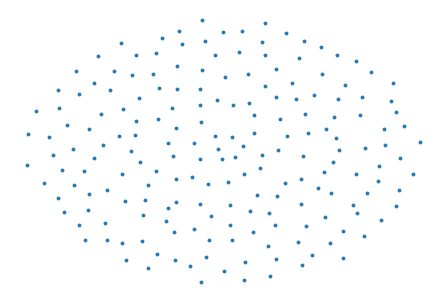

In [115]:
G = nx.Graph()
G = nx.from_pandas_adjacency(mtrx2018)
G.edges(data=True)

nx.draw(G, with_labels=False, edgelist=list(), node_size = 8) 

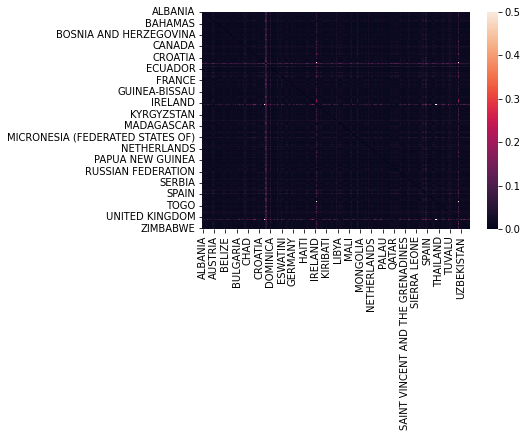

In [116]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 
sns.heatmap(mtrx2018.T, fmt='d')
plt.show()

## Final Notes: Future Refinements

If we were to continue to refine the project, there are several things we'd like to do to either meet goals had initially and did not complete, or refine the project to fix an error we realized later in the project would pose an issue. Some of these may be listed above, but are restated here to provide a concise and compact list for future use. 

### Incomplete Goals
* include abstentions and absenses in the error calculation for each plot to more accurately represent the accuracy of each plot
* do a frequency analysis on abstentions and absenses over time, so that we can determine which countries abstain or are absent the most, and later analyze any patterns we find
* we countries that were not a part of the UN for the each five year period. In the future we would like to use imputation to discover if and/or how the inclusion of countries who joined after the period began affects the outcome of this study.

### Errors
* When determining which categories to use, we excluded all resolutions involving international peacekeeping, security, and weapons as most countries are likely to vote the same way and including this data may neutralize other data in some sense. However, some of the data we included in this category, and excluded from our dataset, are resolutions supporting or antagolizing certain countries in terms of war or international peackeeping situations, which may be relevant to our dataset and to our analysis. Although the resolution to this error is relatively simple, it would take several hours and the issue was found relatively late in the project cycle; we did not have enough time to execute the solution.
* instead of manually determining the categories we wanted to use, it would be nice to somehow figure out which committees each resolution originated from and use those as deterministic factors. This method would be more consistent than relying on our own knowledge and research of each resolution. 
* in our code when reading in data, we assume that the file has already been created. To generalize this and make it accessible to anyone who wants to run this code from scratch, we would to make checks for this to see if the file has been created yet before reading it in. 